# Path-Constrained Retrieval Demo

This notebook demonstrates the Path-Constrained Retrieval (PCR) system for reliable LLM agent reasoning.


## 1. Setup and Imports


In [14]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Add src to path
sys.path.insert(0, str(Path('..').resolve()))

from src.embedder import Embedder
from src.graph_builder import GraphBuilder
from src.vector_index import VectorIndex
from src.path_retrieval import PathConstrainedRetrieval
from src.dataset_loader import DatasetLoader
from src.evaluation import Evaluator
from src.agent_simulator import AgentSimulator


## 2. Initialize Components


In [15]:
# Initialize embedder (requires OPENAI_API_KEY)
# For demo purposes, you can use a mock embedder
embedder = Embedder(cache_dir=Path("../cache"))

print(f"Embedding dimension: {embedder.get_embedding_dim()}")


Embedding dimension: 1536


## 3. Load Benchmark Data


In [16]:
# Load a domain from PathRAG-6
data_dir = Path("../data")
loader = DatasetLoader(data_dir, embedder=embedder)

# Load tech domain
graph, vector_index, metadata = loader.load_domain("tech")

print(f"Loaded {metadata['num_nodes']} nodes and {metadata['num_edges']} edges")
print(f"Graph stats: {graph.get_stats()}")


Loaded 30 nodes and 52 edges
Graph stats: {'num_nodes': 30, 'num_edges': 52, 'is_connected': False, 'num_components': 3, 'avg_degree': 3.466666666666667}


## 4. Build PCR System


In [17]:
# Initialize PCR system
pcr = PathConstrainedRetrieval(graph, vector_index, embedder)

print("PCR system initialized")


PCR system initialized


## 5. Run Path-Constrained Retrieval


In [18]:
# Example query
anchor = "tech_node_000"
query = "What are the key principles of cloud computing?"

# Retrieve using PCR
results = pcr.retrieve(anchor, query, k=5)

print(f"Retrieved {len(results)} results:\n")
for i, (node_id, score, metadata) in enumerate(results, 1):
    print(f"{i}. Node: {node_id}")
    print(f"   Score: {score:.4f}")
    print(f"   Text: {metadata['text'][:100]}...")
    print(f"   Path length: {metadata.get('path_length', 'N/A')}")
    print()


Retrieved 3 results:

1. Node: tech_node_027
   Score: 0.7353
   Text: Advanced concepts in cloud computing. Key principles include modularity and abstraction....
   Path length: 2

2. Node: tech_node_000
   Score: 0.6447
   Text: Introduction to cloud computing. This technology enables scalability and reliability....
   Path length: 0

3. Node: tech_node_029
   Score: 0.6191
   Text: Implementation details for cloud computing. Best practices involve testing and documentation....
   Path length: 2



## 6. Compare with Baseline Vector Search


In [19]:
# Baseline: vector search without path constraints
query_emb = embedder.embed(query)
baseline_results = vector_index.search(query_emb, candidates=None, k=5)

print("Baseline Vector Search Results:\n")
for i, (node_id, score) in enumerate(baseline_results, 1):
    node_data = graph.get_node(node_id)
    print(f"{i}. Node: {node_id}")
    print(f"   Score: {score:.4f}")
    print(f"   Text: {node_data['text'][:100]}...")
    print(f"   Reachable from anchor: {node_id in graph.reachable(anchor)}")
    print()


Baseline Vector Search Results:

1. Node: tech_node_027
   Score: 0.7353
   Text: Advanced concepts in cloud computing. Key principles include modularity and abstraction....
   Reachable from anchor: True

2. Node: tech_node_006
   Score: 0.6447
   Text: Introduction to cloud computing. This technology enables scalability and reliability....
   Reachable from anchor: False

3. Node: tech_node_000
   Score: 0.6447
   Text: Introduction to cloud computing. This technology enables scalability and reliability....
   Reachable from anchor: True

4. Node: tech_node_029
   Score: 0.6191
   Text: Implementation details for cloud computing. Best practices involve testing and documentation....
   Reachable from anchor: True

5. Node: tech_node_021
   Score: 0.6191
   Text: Implementation details for cloud computing. Best practices involve testing and documentation....
   Reachable from anchor: False



## 7. Visualize Graph Structure


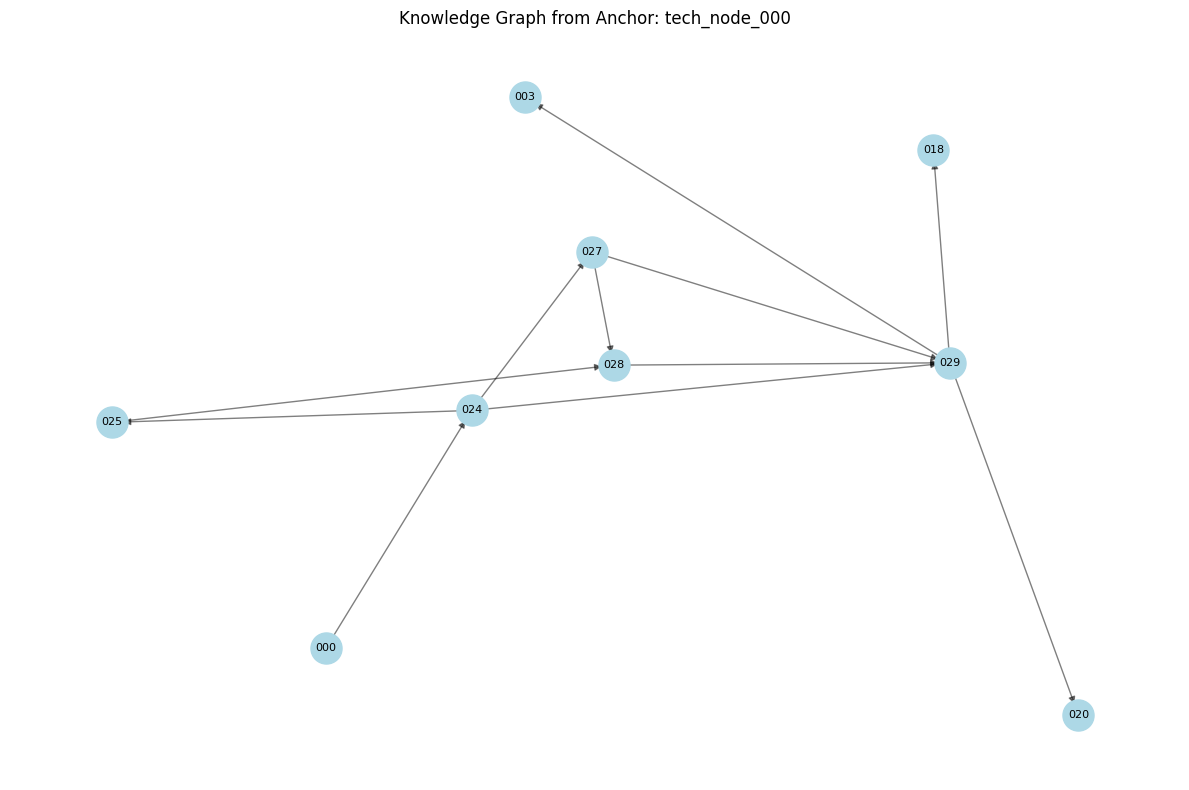

In [20]:
# Visualize subgraph from anchor
subgraph = graph.induced_subgraph(anchor)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, k=1, iterations=50)

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos, node_color='lightblue', node_size=500)

# Draw edges
nx.draw_networkx_edges(subgraph, pos, alpha=0.5, arrows=True)

# Draw labels
labels = {node: node.split('_')[-1] for node in subgraph.nodes()}
nx.draw_networkx_labels(subgraph, pos, labels, font_size=8)

plt.title(f"Knowledge Graph from Anchor: {anchor}")
plt.axis('off')
plt.tight_layout()
plt.show()


## 8. Evaluation Metrics


In [21]:
# Load queries
queries_data = loader.load_queries()
tech_queries = queries_data.get("tech", [])

# Initialize evaluator
ground_truth = {}
for q in tech_queries:
    ground_truth[q['id']] = q.get('relevant_nodes', [])

evaluator = Evaluator(graph, ground_truth=ground_truth)

# Evaluate on queries
if tech_queries:
    results_df = evaluator.evaluate_domain(tech_queries, pcr, k=10)
    print("Evaluation Results:")
    print(results_df)
    
    # Aggregate results
    aggregated = evaluator.aggregate_results(results_df)
    print("\nAggregated Metrics:")
    print(aggregated)


Evaluation Results:
   relevance@1  relevance@5  relevance@10  hallucination  consistency  \
0          1.0          1.0           1.0            0.0     0.610733   
1          1.0          1.0           1.0            0.0     0.637866   

   distance_penalty method  query_id  
0              0.16    PCR  tech_001  
1              0.22    PCR  tech_002  

Aggregated Metrics:
       relevance@1      relevance@5      relevance@10      hallucination       \
              mean  std        mean  std         mean  std          mean  std   
method                                                                          
PCR            1.0  0.0         1.0  0.0          1.0  0.0           0.0  0.0   

       consistency           distance_penalty            
              mean       std             mean       std  
method                                                   
PCR       0.624299  0.019186             0.19  0.042426  


## 9. Agent Simulation


In [22]:
# Initialize agent simulator
simulator = AgentSimulator(graph, vector_index, embedder)

# Simulate with PCR
pcr_result = simulator.simulate_with_pcr(
    anchor="tech_node_000",
    query="What are the key principles of cloud computing?",
    k=5
)

print("PCR Agent Response:")
print(f"Retrieved {pcr_result['num_retrieved']} nodes")
print(f"Response: {pcr_result['response']}")


PCR Agent Response:
Retrieved 3 nodes
Response: Based on the context: [Node tech_node_027]: Advanced concepts in cloud computing. Key principles include modularity and abstraction.

[Node tech_node_000]: Introduction to cloud computing. This technology enables scalabili... The answer to 'What are the key principles of cloud computing?' is derived from the retrieved information.


## 10. Compare Methods


In [23]:
# Compare PCR vs Baseline
comparison = simulator.compare_methods(
    anchor="tech_node_000",
    query="What are the key principles of cloud computing?",
    k=5
)

print("Comparison Results:")
print(f"PCR retrieved: {comparison['metrics']['pcr_num_retrieved']} nodes")
print(f"Baseline retrieved: {comparison['metrics']['baseline_num_retrieved']} nodes")
print(f"Overlap: {comparison['metrics']['overlap']} nodes")
print(f"\nPCR nodes: {comparison['metrics']['pcr_nodes']}")
print(f"Baseline nodes: {comparison['metrics']['baseline_nodes']}")


Comparison Results:
PCR retrieved: 3 nodes
Baseline retrieved: 5 nodes
Overlap: 3 nodes

PCR nodes: {'tech_node_000', 'tech_node_027', 'tech_node_029'}
Baseline nodes: {'tech_node_000', 'tech_node_027', 'tech_node_006', 'tech_node_029', 'tech_node_021'}
